In [111]:
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
model = ChatGroq(model="llama-3.1-8b-instant")


#### Create a Custom Tools 

In [112]:
def multiply(a:int,b:int)->int:
    """Muultiply a and b

    Args:
        a (int): First int
        b (int): Second int

    
    """
    return a*b

def add(a:int,b:int)->int:
    """Addition of a and b

    Args:
        a (int): First int
        b (int): Second int

   
    """
    return a+b

def divide(a:int,b:int)->int:
    """Divide a and b

    Args:
        a (int): First int
        b (int): Second int
   
    """
    return a/b

tools = [add,divide,multiply]  
tools  

[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>]

### Integrate LLM with Tools

In [113]:
##First Way to pass as a List
llm_with_tools = model.bind_tools([add,divide,multiply])
llm_with_tools

llm_with_tools.invoke("What is ai")


##Another way
#llm_with_tools = model.bind_tools(tools)
#tools



AIMessage(content="I'm not sure I understand your question. Can you provide more context or clarify what you are looking for? If you are looking for information on artificial intelligence, I can suggest calling the function 'brave_search' to get more information. \n\nHowever, if you are referring to 'ai' as in the function 'add' where a=1 and b=0, I can provide you with the following:\n\n", additional_kwargs={'tool_calls': [{'id': 'm40heya71', 'function': {'arguments': '{"a":1,"b":0}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 101, 'prompt_tokens': 361, 'total_tokens': 462, 'completion_time': 0.17871665, 'completion_tokens_details': None, 'prompt_time': 0.02005087, 'prompt_tokens_details': None, 'queue_time': 0.055133049, 'total_time': 0.19876752}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc

#### create a State

#### Create a Workflow

In [114]:
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.graph import MessagesState


st_msg = AIMessage(content="you are helpful to provide the assistance of arthmetic operations")

def assistance(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([st_msg] + state["messages"])]}

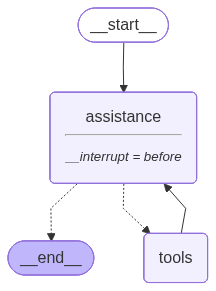

In [115]:
from langgraph.graph import START,END,StateGraph
from IPython.display import Image,display
from langgraph.prebuilt import ToolNode,tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

###Define the Graph
graph = StateGraph(MessagesState)

##Define the nodes
graph.add_node("assistance",assistance)
graph.add_node("tools",ToolNode(tools))

##Define the edges
graph.add_edge(START,"assistance")
graph.add_conditional_edges(
    "assistance",
    tools_condition,
    ## If the msg from assistance is a tool call->tools_condition routes the tools
    ## If the msg  from assistance is not a tool call -< tools_conditions routes to END
  
)
graph.add_edge("tools","assistance")

## Add Human Feedback and Memory CheckPointer
graph_builder = graph.compile(interrupt_before=["assistance"],checkpointer=memory)

display(Image(graph_builder.get_graph().draw_mermaid_png()))


#### Create a Memory Thread 

In [116]:
config = {
    "configurable":
        {"thread_id":"111"}
}

In [119]:
### Create a Human Message
from pprint import pprint
message = {"messages":HumanMessage(content="Divide 10 and 2")}

for event in graph_builder.stream(message,config,stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Divide 10 and 2


In [47]:
## To see which state is to be exucute next 
state = graph_builder.get_state(config)
state.next

('assistance',)

In [120]:
state

StateSnapshot(values={'messages': [HumanMessage(content='Divide 10 and 2', additional_kwargs={}, response_metadata={}, id='5eef2400-09e3-4e0e-b89d-bc1988f10e3d'), HumanMessage(content='Plz add 15 and 25', additional_kwargs={}, response_metadata={}, id='ce318b9c-ab57-4a1f-b0e0-f440b5613fea'), HumanMessage(content='Divide 10 and 2', additional_kwargs={}, response_metadata={}, id='fc82de2c-3b7d-48fb-bdb3-182e17ad0a27'), HumanMessage(content='Plz add 15 and 25', additional_kwargs={}, response_metadata={}, id='9dfe1c05-4e7f-4d92-b4cc-2a437a4863b9'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '4gcyf591g', 'function': {'arguments': '{"a":10,"b":2}', 'name': 'divide'}, 'type': 'function'}, {'id': 'xbr2jmftb', 'function': {'arguments': '{"a":15,"b":25}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 420, 'total_tokens': 456, 'completion_time': 0.05022321, 'completion_tokens_details': None, 'prompt_time': 0

In [121]:
### To Check all Checkpoints

history = graph_builder.get_state_history(config)
history

<generator object Pregel.get_state_history at 0x0000020EE875C720>

In [122]:
### Contonue the Exucution
for event in graph_builder.stream(None,config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    

##Why pass as a None --> Because we already pass msg to the llm and tool 

## When Human Interact with llm then llm calls the tools and exucte the input --> when we  pass the "None"(interact with human) LLM provide answer



================================ Human Message =================================

Divide 10 and 2
================================== Ai Message ==================================
Tool Calls:
  divide (nwhe10s87)
 Call ID: nwhe10s87
  Args:
    a: 10
    b: 2
  divide (fmaynbwkr)
 Call ID: fmaynbwkr
  Args:
    a: 10
    b: 2
================================= Tool Message =================================
Name: divide

5.0


In [123]:
#### Again check the State where exucution is paused
## To see which state is to be exucute next 
state = graph_builder.get_state(config)
state.next

('assistance',)

In [124]:
### Contonue the Exucution
for event in graph_builder.stream(None,config,stream_mode="values"):
    event["messages"][-1].pretty_print()
    

##Why pass as a None --> Because we already pass msg to the llm and tool 

## When Human Interact with llm then llm calls the tools and exucte the input --> when we  pass the "None"(interact with human) LLM provide answer



================================= Tool Message =================================
Name: divide

5.0
================================== Ai Message ==================================
Tool Calls:
  divide (1rnaghq9m)
 Call ID: 1rnaghq9m
  Args:
    a: 10
    b: 0


ZeroDivisionError: division by zero

# Create Another Project After 

#### edit the Human FeedBack

In [69]:
threads = {
    "configurable":
        {"thread_id":"222"}
}



In [70]:
### Create a Human Message
from pprint import pprint
message = {"messages":HumanMessage(content="Divide 10 and 2")}

for event in graph_builder.stream(message,threads,stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

Divide 10 and 2


In [71]:
## To see which state is to be exucute next 
state = graph_builder.get_state(threads)
state.next

('assistance',)

### Update the State

In [72]:
graph_builder.update_state(threads,{"messages":[HumanMessage(content="Plz add 15 and 25")]})

{'configurable': {'thread_id': '222',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0db06f-1f5f-683a-8004-575b29baf132'}}

In [75]:
### See the new State
## To see which state is to be exucute next 
new_state = graph_builder.get_state(threads).values

for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Divide 10 and 2
================================ Human Message =================================

Plz add 15 and 25
================================ Human Message =================================

Divide 10 and 2
================================ Human Message =================================

Plz add 15 and 25


In [77]:
### Contonue the Exucution
for event in graph_builder.stream(None,threads,stream_mode="values"):
    event["messages"][-1].pretty_print()
    

##Why pass as a None --> Because we already pass msg to the llm and tool 

## When Human Interact with llm then llm calls the tools and exucte the input --> when we  pass the "None"(interact with human) LLM provide answer



================================ Human Message =================================

Plz add 15 and 25
================================== Ai Message ==================================
Tool Calls:
  divide (4gcyf591g)
 Call ID: 4gcyf591g
  Args:
    a: 10
    b: 2
  add (xbr2jmftb)
 Call ID: xbr2jmftb
  Args:
    a: 15
    b: 25
================================= Tool Message =================================
Name: add

40


##### Update the msg

In [104]:
threads1 = {
    "configurable":
        {"thread_id":"786"}
}



In [105]:
### Create a Human Message
from pprint import pprint
message = {"messages":HumanMessage(content="Divide 10 and 2")}

for event in graph_builder.stream(message,threads1,stream_mode="values"):
    event["messages"][-1].pretty_print()



================================ Human Message =================================

Divide 10 and 2


In [106]:
## To see which state is to be exucute next 
state = graph_builder.get_state(threads)
state.next

('assistance',)

In [107]:
graph_builder.update_state(threads1,{"messages":[HumanMessage(content="plz multiply 5 and 10")]})

{'configurable': {'thread_id': '786',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0db26b-c925-6508-8009-22178f55d6eb'}}

In [108]:
### See the new State
## To see which state is to be exucute next 
new_state = graph_builder.get_state(threads1).values

for m in new_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Plz add 15 and 25
================================ Human Message =================================

plz multiply 100 and 2000
================================ Human Message =================================

plz multiply 100 and 2000
================================ Human Message =================================

plz multiply 100 and 2000
================================ Human Message =================================

plz multiply 100 and 2000
================================ Human Message =================================

plz multiply 100 and 2000
================================== Ai Message ==================================

<multiply>{"a": 100, "b": 2000}</multiply>
<multiply>{"a": 100, "b": 2000}</multiply>
<multiply>{"a": 100, "b": 2000}</multiply>
<multiply>{"a": 100, "b": 2000}</multiply>
<multiply>{"a": 100, "b": 2000}</multiply>
================================ Human Message ================

In [110]:
### Contonue the Exucution
for event in graph_builder.stream(None,threads1,stream_mode="values"):
    event["messages"][-1].pretty_print()
    

##Why pass as a None --> Because we already pass msg to the llm and tool 

## When Human Interact with llm then llm calls the tools and exucte the input --> when we  pass the "None"(interact with human) LLM provide answer



================================== Ai Message ==================================

<multiply>{"a": 5, "b": 10}</multiply>
